In [1]:
# Importer la bibliothèque pour monter Google Drive
from google.colab import drive
# Monter Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops

In [3]:
def indexer_images_couleur(chemin_repertoire):
    index = {}
    for nom_fichier in os.listdir(chemin_repertoire):
        chemin_fichier = os.path.join(chemin_repertoire, nom_fichier)
        if chemin_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(chemin_fichier)
            histogramme = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            index[nom_fichier] = histogramme.flatten()
    return index


In [4]:
def rechercher_images_similaires_couleurs(index, histogramme_requete, nombre_resultats=5):
    distances = []
    for nom_fichier, histogramme_indexe in index.items():
        distance = np.linalg.norm(histogramme_requete - histogramme_indexe)
        distances.append((nom_fichier, distance))
    distances.sort(key=lambda x: x[1])
    return distances[:nombre_resultats]


In [5]:
def indexer_images_gris(chemin_repertoire):
    index = {}
    for nom_fichier in os.listdir(chemin_repertoire):
        chemin_fichier = os.path.join(chemin_repertoire, nom_fichier)
        if chemin_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
            image = cv2.imread(chemin_fichier, cv2.IMREAD_GRAYSCALE)
            histogramme = cv2.calcHist([image], [0], None, [8], [0, 256])
            index[nom_fichier] = histogramme.flatten()
    return index


In [6]:
def rechercher_images_similaires_gris(index, histogramme_requete, nombre_resultats=5):
    distances = []
    for nom_fichier, histogramme_indexe in index.items():
        distance = np.linalg.norm(histogramme_requete - histogramme_indexe)
        distances.append((nom_fichier, distance))
    distances.sort(key=lambda x: x[1])
    return distances[:nombre_resultats]


In [7]:
def calculer_correlogramme(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return correlation


In [8]:
def indexer_images_correlogramme(chemin_repertoire):
    index = {}
    for nom_fichier in os.listdir(chemin_repertoire):
        if nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
            chemin_image = os.path.join(chemin_repertoire, nom_fichier)
            correlation = calculer_correlogramme(chemin_image)
            if correlation is not None:
                index[nom_fichier] = correlation
    return index


In [9]:
def rechercher_images_similaires_correlogramme(chemin_image_requete, index_images, nombre_resultats=5):
    correlation_requete = calculer_correlogramme(chemin_image_requete)
    distances = {}
    for nom_fichier, correlation_indexe in index_images.items():
        distance = abs(correlation_requete - correlation_indexe)
        distances[nom_fichier] = distance
    images_similaires = sorted(distances.items(), key=lambda item: item[1])
    return images_similaires[:nombre_resultats]


In [10]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
# Charger le modèle AlexNet pré-entraîné sans la dernière couche de classification
model_alexnet = models.alexnet(pretrained=True)
model_alexnet.classifier = torch.nn.Sequential(*list(model_alexnet.classifier.children())[:-1])  # Retirer la dernière couche
model_alexnet.eval()  # Mode évaluation pour désactiver Dropout etc.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 95.3MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
# Fonction pour extraire les features avec AlexNet
def extraire_features_alexnet(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),  # AlexNet attend 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)  # Ajouter dimension batch

    with torch.no_grad():
        features = model_alexnet(img_tensor)
    return features.numpy().flatten()

In [12]:
# Fonction pour rechercher les images similaires avec AlexNet
def rechercher_images_similaires_alexnet(chemin_image_requete, index_images, nombre_resultats=5):
    features_requete = extraire_features_alexnet(chemin_image_requete)
    distances = {}
    for nom_fichier, features_indexe in index_images.items():
        distance = np.linalg.norm(features_requete - features_indexe)
        distances[nom_fichier] = distance

    images_similaires = sorted(distances.items(), key=lambda item: item[1])
    return images_similaires[:nombre_resultats]

In [13]:
# Fonction pour indexer des images avec AlexNet
def indexer_images_alexnet(dossier_images):
    index = {}
    for nom_fichier in os.listdir(dossier_images):
        chemin_image = os.path.join(dossier_images, nom_fichier)
        if chemin_image.lower().endswith(('.png', '.jpg', '.jpeg')):
            features = extraire_features_alexnet(chemin_image)
            index[nom_fichier] = features
    return index

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Charger le modèle VGG16 pré-entraîné sans la couche de classification (top)
base_model = VGG16(weights='imagenet', include_top=False)
model_vgg16 = Model(inputs=base_model.input, outputs=base_model.output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [15]:
# Fonction pour extraire les caractéristiques d'une image avec le modèle VGG16
def extraire_features_vgg16(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  #Charger l'image et la redimensionner à 224x224 (taille requise par VGG16)
    img_array = image.img_to_array(img)     # Convertir l'image en un tableau numpy
    img_array = np.expand_dims(img_array, axis=0)# Ajouter une dimension supplémentaire pour représenter le batch (VGG16 attend une entrée de batch)
    img_array = preprocess_input(img_array)  # Prétraiter l'image pour qu'elle corresponde aux attentes de VGG16
    features = model_vgg16.predict(img_array)    # Extraire les caractéristiques à partir du modèle VGG16
    return features.flatten() # Aplatir le tableau des caractéristiques pour le rendre 1D


In [16]:
# Fonction pour indexer un ensemble d'images en utilisant VGG16
def indexer_images_vgg16(dossier_images):
    index = {}
    for nom_fichier in os.listdir(dossier_images):
        chemin_image = os.path.join(dossier_images, nom_fichier)
        if chemin_image.lower().endswith(('.png', '.jpg', '.jpeg')):
            features = extraire_features_vgg16(chemin_image)
            index[nom_fichier] = features
    return index


In [17]:
# Fonction pour rechercher les images similaires à une image requête en utilisant les caractéristiques VGG16
def rechercher_images_similaires_vgg16(chemin_image_requete, index_images, nombre_resultats=5):
    features_requete = extraire_features_vgg16(chemin_image_requete)
    distances = {}  # Dictionnaire pour stocker les distances entre l'image requête et les images indexées
    for nom_fichier, features_indexe in index_images.items():
        distance = np.linalg.norm(features_requete - features_indexe) # Calculer la distance euclidienne entre les caractéristiques de l'image requête et celles de l'image indexée
        distances[nom_fichier] = distance
    images_similaires = sorted(distances.items(), key=lambda item: item[1])
    return images_similaires[:nombre_resultats]


In [18]:
def choix_descripteur():
    print("Choisissez un descripteur :")
    print("1. Histogramme couleur")
    print("2. Histogramme gris")
    print("3. Corrélogramme")
    print("4. VGG16")
    print("5. AlexNet")

    choix = input("Entrez le numéro du descripteur (1, 2, 3, 4 ou 5) : ")

    if choix == '1':
        return 'couleur'
    elif choix == '2':
        return 'gris'
    elif choix == '3':
        return 'correlogramme'
    elif choix == '4':
        return 'vgg16'
    elif choix == '5':
        return 'alexnet'
    else:
        print("Choix invalide, essayez encore.")
        return choix_descripteur()


In [19]:
def indexer_images_par_type(chemin_repertoire, descripteur):
    if descripteur == 'couleur':
        return indexer_images_couleur(chemin_repertoire)
    elif descripteur == 'gris':
        return indexer_images_gris(chemin_repertoire)
    elif descripteur == 'correlogramme':
        return indexer_images_correlogramme(chemin_repertoire)
    elif descripteur == 'vgg16':
        return indexer_images_vgg16(chemin_repertoire)
    elif descripteur == 'alexnet':
        return indexer_images_alexnet(chemin_repertoire)
    else:
        raise ValueError("Descripteur non supporté")


In [20]:
def rechercher_images_similaires_par_type(chemin_image_requete, descripteur, index_images):
    image_requete = cv2.imread(chemin_image_requete)
    if image_requete is None:
        raise ValueError(f"L'image requête '{chemin_image_requete}' n'a pas pu être chargée.")

    if descripteur == 'couleur':
        histogramme_requete = cv2.calcHist([image_requete], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
        return rechercher_images_similaires_couleurs(index_images, histogramme_requete)

    elif descripteur == 'gris':
        image_requete_gris = cv2.imread(chemin_image_requete, cv2.IMREAD_GRAYSCALE)
        if image_requete_gris is None:
            raise ValueError(f"L'image requête '{chemin_image_requete}' n'a pas pu être chargée en niveaux de gris.")
        histogramme_requete = cv2.calcHist([image_requete_gris], [0], None, [8], [0, 256]).flatten()
        return rechercher_images_similaires_gris(index_images, histogramme_requete)

    elif descripteur == 'correlogramme':
        return rechercher_images_similaires_correlogramme(chemin_image_requete, index_images)

    elif descripteur == 'vgg16':
        return rechercher_images_similaires_vgg16(chemin_image_requete, index_images)

    elif descripteur == 'alexnet':
        return rechercher_images_similaires_alexnet(chemin_image_requete, index_images)

    else:
        raise ValueError("Descripteur non supporté")


Choisissez un descripteur :
1. Histogramme couleur
2. Histogramme gris
3. Corrélogramme
4. VGG16
5. AlexNet
Entrez le numéro du descripteur (1, 2, 3, 4 ou 5) : 4
Entrez le chemin du dossier d'images : /content/drive/MyDrive/proj_index/avocado
Entrez le chemin de l'image requête : /content/drive/MyDrive/proj_index/avocadoo.jpg
Indexation en cours...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

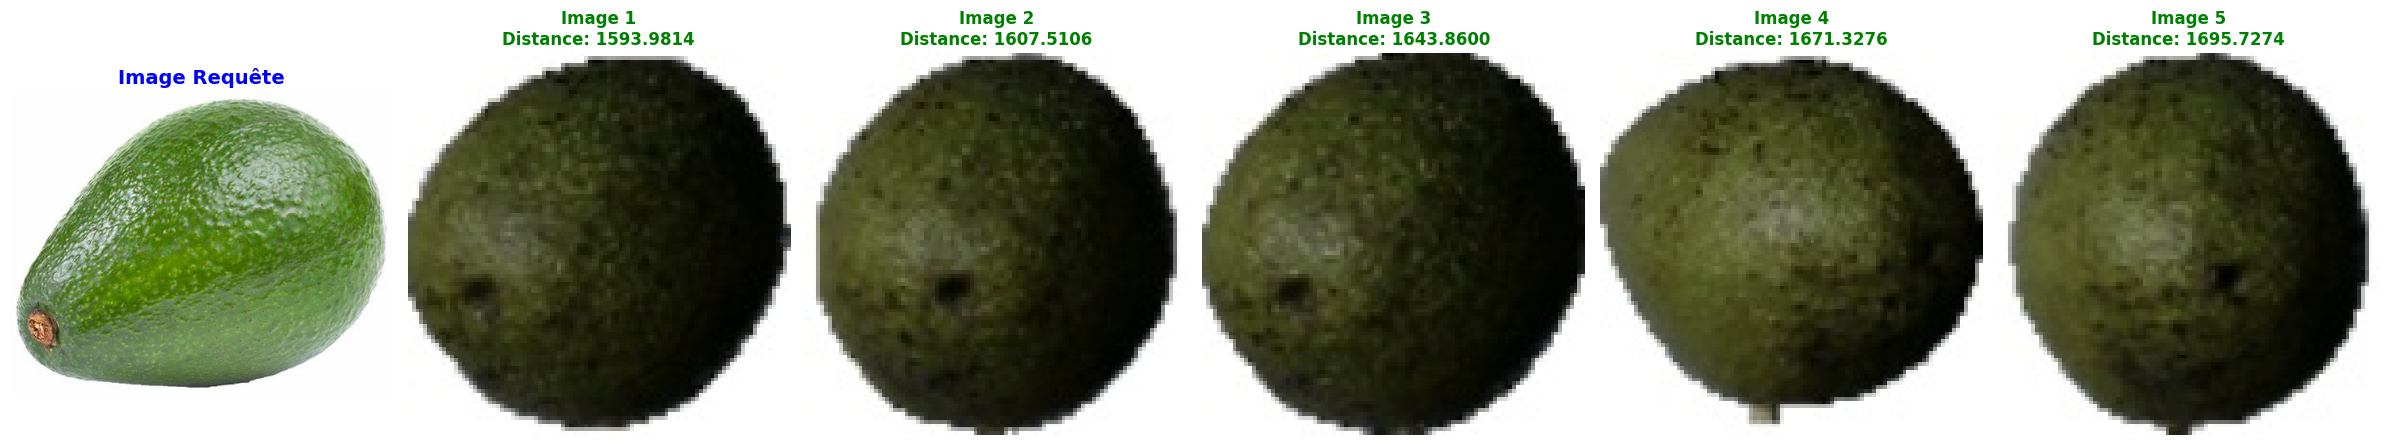

In [21]:
import matplotlib.pyplot as plt
def interface_colab():
    descripteur = choix_descripteur()
    chemin_repertoire = input("Entrez le chemin du dossier d'images : ")
    chemin_image_requete = input("Entrez le chemin de l'image requête : ")

    try:
        print("Indexation en cours...")
        index_images = indexer_images_par_type(chemin_repertoire, descripteur)
        print("Recherche d'images similaires...")
        resultats = rechercher_images_similaires_par_type(chemin_image_requete, descripteur, index_images)
        print("\nLes 5 images les plus similaires sont :")

        # Lecture de l'image requête
        img_requete = cv2.imread(chemin_image_requete)
        if img_requete is None:
            print(f"Erreur lors de la lecture de l'image requête {chemin_image_requete}")
            return
        img_requete = cv2.cvtColor(img_requete, cv2.COLOR_BGR2RGB)  # conversion BGR -> RGB

        # Préparer l'affichage des images (image requête + images similaires)
        fig, axes = plt.subplots(1, 6, figsize=(24, 5))  # 6 images, 1 pour la requête + 5 similaires

        # Affichage de l'image requête dans le premier subplot
        axes[0].imshow(img_requete)
        axes[0].axis('off')
        axes[0].set_title("Image Requête", fontsize=14, color='blue', weight='bold')

        # Affichage des images similaires
        for idx, (chemin, distance) in enumerate(resultats[:5]):
            img_path = os.path.join(chemin_repertoire, chemin)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Erreur lors de la lecture de l'image {chemin}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # conversion BGR -> RGB

            # Affichage de l'image similaire
            axes[idx+1].imshow(img)
            axes[idx+1].axis('off')  # Masquer les axes
            axes[idx+1].set_title(f"Image {idx+1}\nDistance: {distance:.4f}", fontsize=12, color='green', weight='bold')

        # Améliorer l'apparence de l'affichage
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print("Erreur :", e)

# Lance tout
interface_colab()
